In [1]:
import pandas as pd
import umap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
import hdbscan

%matplotlib inline

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

In [2]:
final_df = pd.read_csv("../data/processed/final_df.csv")

In [3]:
final_df.head()

,id_student,age_band,gender,highest_education,n_assignments,mean_score,final_result,total_clicks,studied_credits,region,code_module,code_presentation,press_mod
0,11391,55<=,M,HE Qualification,5,82.0,Pass,934,240,East Anglian Region,AAA,2013J,2013J-AAA
1,28400,35-55,F,HE Qualification,5,66.4,Pass,1435,60,Scotland,AAA,2013J,2013J-AAA
2,31604,35-55,F,A Level or Equivalent,5,76.0,Pass,2158,60,South East Region,AAA,2013J,2013J-AAA
3,32885,0-35,F,Lower Than A Level,5,54.4,Pass,1034,60,West Midlands Region,AAA,2013J,2013J-AAA
4,38053,35-55,M,A Level or Equivalent,5,68.0,Pass,2445,60,Wales,AAA,2013J,2013J-AAA


In [4]:
final_df.dtypes

id_student             int64
age_band              object
gender                object
highest_education     object
n_assignments          int64
mean_score           float64
final_result          object
total_clicks           int64
studied_credits        int64
region                object
code_module           object
code_presentation     object
press_mod             object
dtype: object

In [5]:
final_df.mean_score.min()

0.0

Separating numerical and categorical columns

In [6]:
num_res_df = pd.DataFrame(data=final_df, columns=["n_assignments", "mean_score", "total_clicks", "studied_credits","id_student", "final_result"])



In [7]:
#find null values
num_res_df[num_res_df.isnull().any(axis=1)]

,n_assignments,mean_score,total_clicks,studied_credits,id_student,final_result
797,0,NaN,30,120,186780,Withdrawn
1734,0,NaN,75,60,549713,Withdrawn
1843,0,NaN,21,60,554393,Fail
4498,0,NaN,9,120,606501,Withdrawn
6171,0,NaN,31,60,654422,Withdrawn
13730,0,NaN,155,60,555297,Withdrawn
13768,0,NaN,576,60,557247,Withdrawn
13769,0,NaN,576,60,557247,Withdrawn
14355,0,NaN,317,120,427248,Withdrawn
17039,0,NaN,62,60,676642,Withdrawn


In [8]:
#replace nan with mean value
num_res_df["mean_score"].fillna(72.83, inplace = True)

In [9]:
num_res_df.describe()

,n_assignments,mean_score,total_clicks,studied_credits,id_student
count,26721.000000,26721.000000,26721.000000,26721.000000,2.672100e+04
mean,7.747315,72.837882,1792.429812,77.769357,7.085816e+05
std,4.542077,15.554484,2094.342100,39.026739,5.540723e+05
min,0.000000,0.000000,1.000000,30.000000,6.516000e+03
25%,4.000000,64.800000,460.000000,60.000000,5.058780e+05
50%,7.000000,75.714286,1082.000000,60.000000,5.893270e+05
75%,11.000000,84.047619,2383.000000,90.000000,6.421960e+05
max,28.000000,100.000000,28615.000000,630.000000,2.698588e+06


In [10]:
#replace "0s" with mean
num_res_df['n_assignments'] = np.where((num_res_df.n_assignments == 0), 7, num_res_df.n_assignments)


In [11]:
num_res_df['mean_score'] = np.where((num_res_df.mean_score == 0.0), 72.83, num_res_df.mean_score)

In [12]:
num_res_df

,n_assignments,mean_score,total_clicks,studied_credits,id_student,final_result
0,5,82.000000,934,240,11391,Pass
1,5,66.400000,1435,60,28400,Pass
2,5,76.000000,2158,60,31604,Pass
3,5,54.400000,1034,60,32885,Pass
4,5,68.000000,2445,60,38053,Pass
...,...,...,...,...,...,...
26716,9,88.888889,476,30,2620947,Distinction
26717,9,88.111111,893,30,2645731,Distinction
26718,9,76.666667,312,30,2648187,Pass
26719,2,91.500000,275,30,2679821,Withdrawn


In [13]:
num_res_df['final_result'] = num_res_df['final_result'].apply(lambda x: str(x).replace('Distinction','4'))
num_res_df['final_result'] = num_res_df['final_result'].apply(lambda x: str(x).replace('Pass','3'))
num_res_df['final_result'] = num_res_df['final_result'].apply(lambda x: str(x).replace('Fail','2'))
num_res_df['final_result'] = num_res_df['final_result'].apply(lambda x: str(x).replace('Withdrawn','1'))

In [14]:
num_res_df

,n_assignments,mean_score,total_clicks,studied_credits,id_student,final_result
0,5,82.000000,934,240,11391,3
1,5,66.400000,1435,60,28400,3
2,5,76.000000,2158,60,31604,3
3,5,54.400000,1034,60,32885,3
4,5,68.000000,2445,60,38053,3
...,...,...,...,...,...,...
26716,9,88.888889,476,30,2620947,4
26717,9,88.111111,893,30,2645731,4
26718,9,76.666667,312,30,2648187,3
26719,2,91.500000,275,30,2679821,1


In [15]:
num_res_df.set_index(['id_student'], inplace=True)

In [22]:
num_res_df.dtypes

n_assignments        int64
mean_score         float64
total_clicks         int64
studied_credits      int64
final_result        object
dtype: object

In [24]:
num_res_df=num_res_df.astype(int)

In [26]:
num_res_df.dtypes

n_assignments      int64
mean_score         int64
total_clicks       int64
studied_credits    int64
final_result       int64
dtype: object

In [34]:
#num_res_df.to_csv('../data/processed/numeric_results_df.csv', index=False)

In [27]:
num_res_log = np.log(num_res_df)

In [ ]:
#to numpy

In [28]:
np_num_log = num_res_log.to_numpy()

# UMAP LOG

In [30]:
reducer = umap.UMAP(random_state=42)
reducer.fit(np_num_log.data)

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=42, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=False)

In [31]:
embedding = reducer.transform(np_num_log.data)


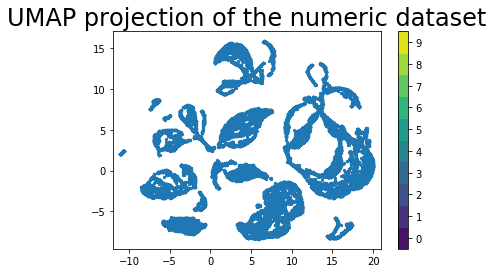

In [32]:
plt.scatter(embedding[:, 0], embedding[:, 1], cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the numeric dataset', fontsize=24);

# UMAP StandardScaler

In [37]:
transformer = \
Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), 
                ('scaler', StandardScaler())])


In [38]:
FEATS = ['n_assignments', 'mean_score','final_result', 'total_clicks', 'studied_credits']
preprocessor = \
ColumnTransformer(transformers=[('num', transformer, FEATS)])

In [39]:
preprocessor

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('num',
                                 Pipeline(memory=None,
                                          steps=[('imputer',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=None,
                                                                missing_values=nan,
                                                                strategy='mean',
                                                                verbose=0)),
                                                 ('scaler',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                             

In [40]:
blind = pd.DataFrame(data=preprocessor.fit_transform(num_res_df))

In [41]:
blind

,0,1,2,3,4
0,-0.606588,0.617403,0.548775,-0.409888,4.156988
1,-0.606588,-0.427482,0.548775,-0.170668,-0.455321
2,-0.606588,0.225571,0.548775,0.174555,-0.455321
3,-0.606588,-1.211146,0.548775,-0.362140,-0.455321
4,-0.606588,-0.296872,0.548775,0.311593,-0.455321
...,...,...,...,...,...
26716,0.274987,1.009235,1.610139,-0.628577,-1.224039
26717,0.274987,1.009235,1.610139,-0.429465,-1.224039
26718,0.274987,0.225571,0.548775,-0.706884,-1.224039
26719,-1.267770,1.205151,-1.573954,-0.724551,-1.224039


In [43]:
blind_np = blind.to_numpy()

In [44]:
reducer_sclr = umap.UMAP(random_state=42)
reducer_sclr.fit(blind_np.data)

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=42, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=False)

In [45]:
embedding_sclr = reducer_sclr.transform(blind_np.data)


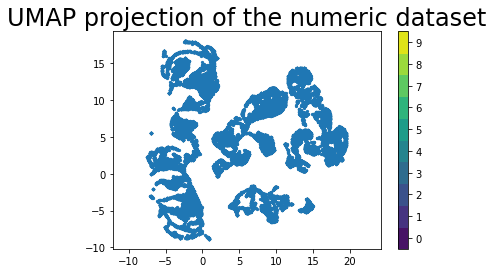

In [46]:
plt.scatter(embedding_sclr[:, 0], embedding_sclr[:, 1], cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the numeric dataset', fontsize=24);

# UMAP StandardScaler Median

In [47]:
transformer_med = \
Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), 
                ('scaler', StandardScaler())])


In [48]:
preprocessor_med = \
ColumnTransformer(transformers=[('num', transformer, FEATS)])

In [49]:
preprocessor_med

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('num',
                                 Pipeline(memory=None,
                                          steps=[('imputer',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=None,
                                                                missing_values=nan,
                                                                strategy='mean',
                                                                verbose=0)),
                                                 ('scaler',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                             

In [50]:
blind_med = pd.DataFrame(data=preprocessor_med.fit_transform(num_res_df))

In [53]:
blind_med_np = blind_med.to_numpy()

In [55]:
reducer_med = umap.UMAP(random_state=42)
reducer_med.fit(blind_med_np.data)

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=42, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=False)

In [56]:
embedding_med = reducer_med.transform(blind_med_np.data)


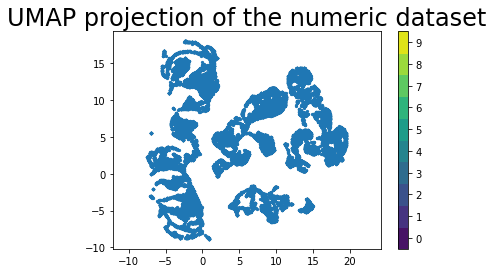

In [57]:
plt.scatter(embedding_med[:, 0], embedding_med[:, 1], cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the numeric dataset', fontsize=24);